## Hands-on #3: Quantization with PLiNIO



In this notebook, you will:
1. Load the optimized and pruned DNN found at the end of Hands-on #2
2. Apply Quantization-Aware Training (QAT) to it.
3. Export the final model in an ONNX format compatible with the AI Compiler that you will use in Hands-on #4.

Considering the flow seen in class, we are here:

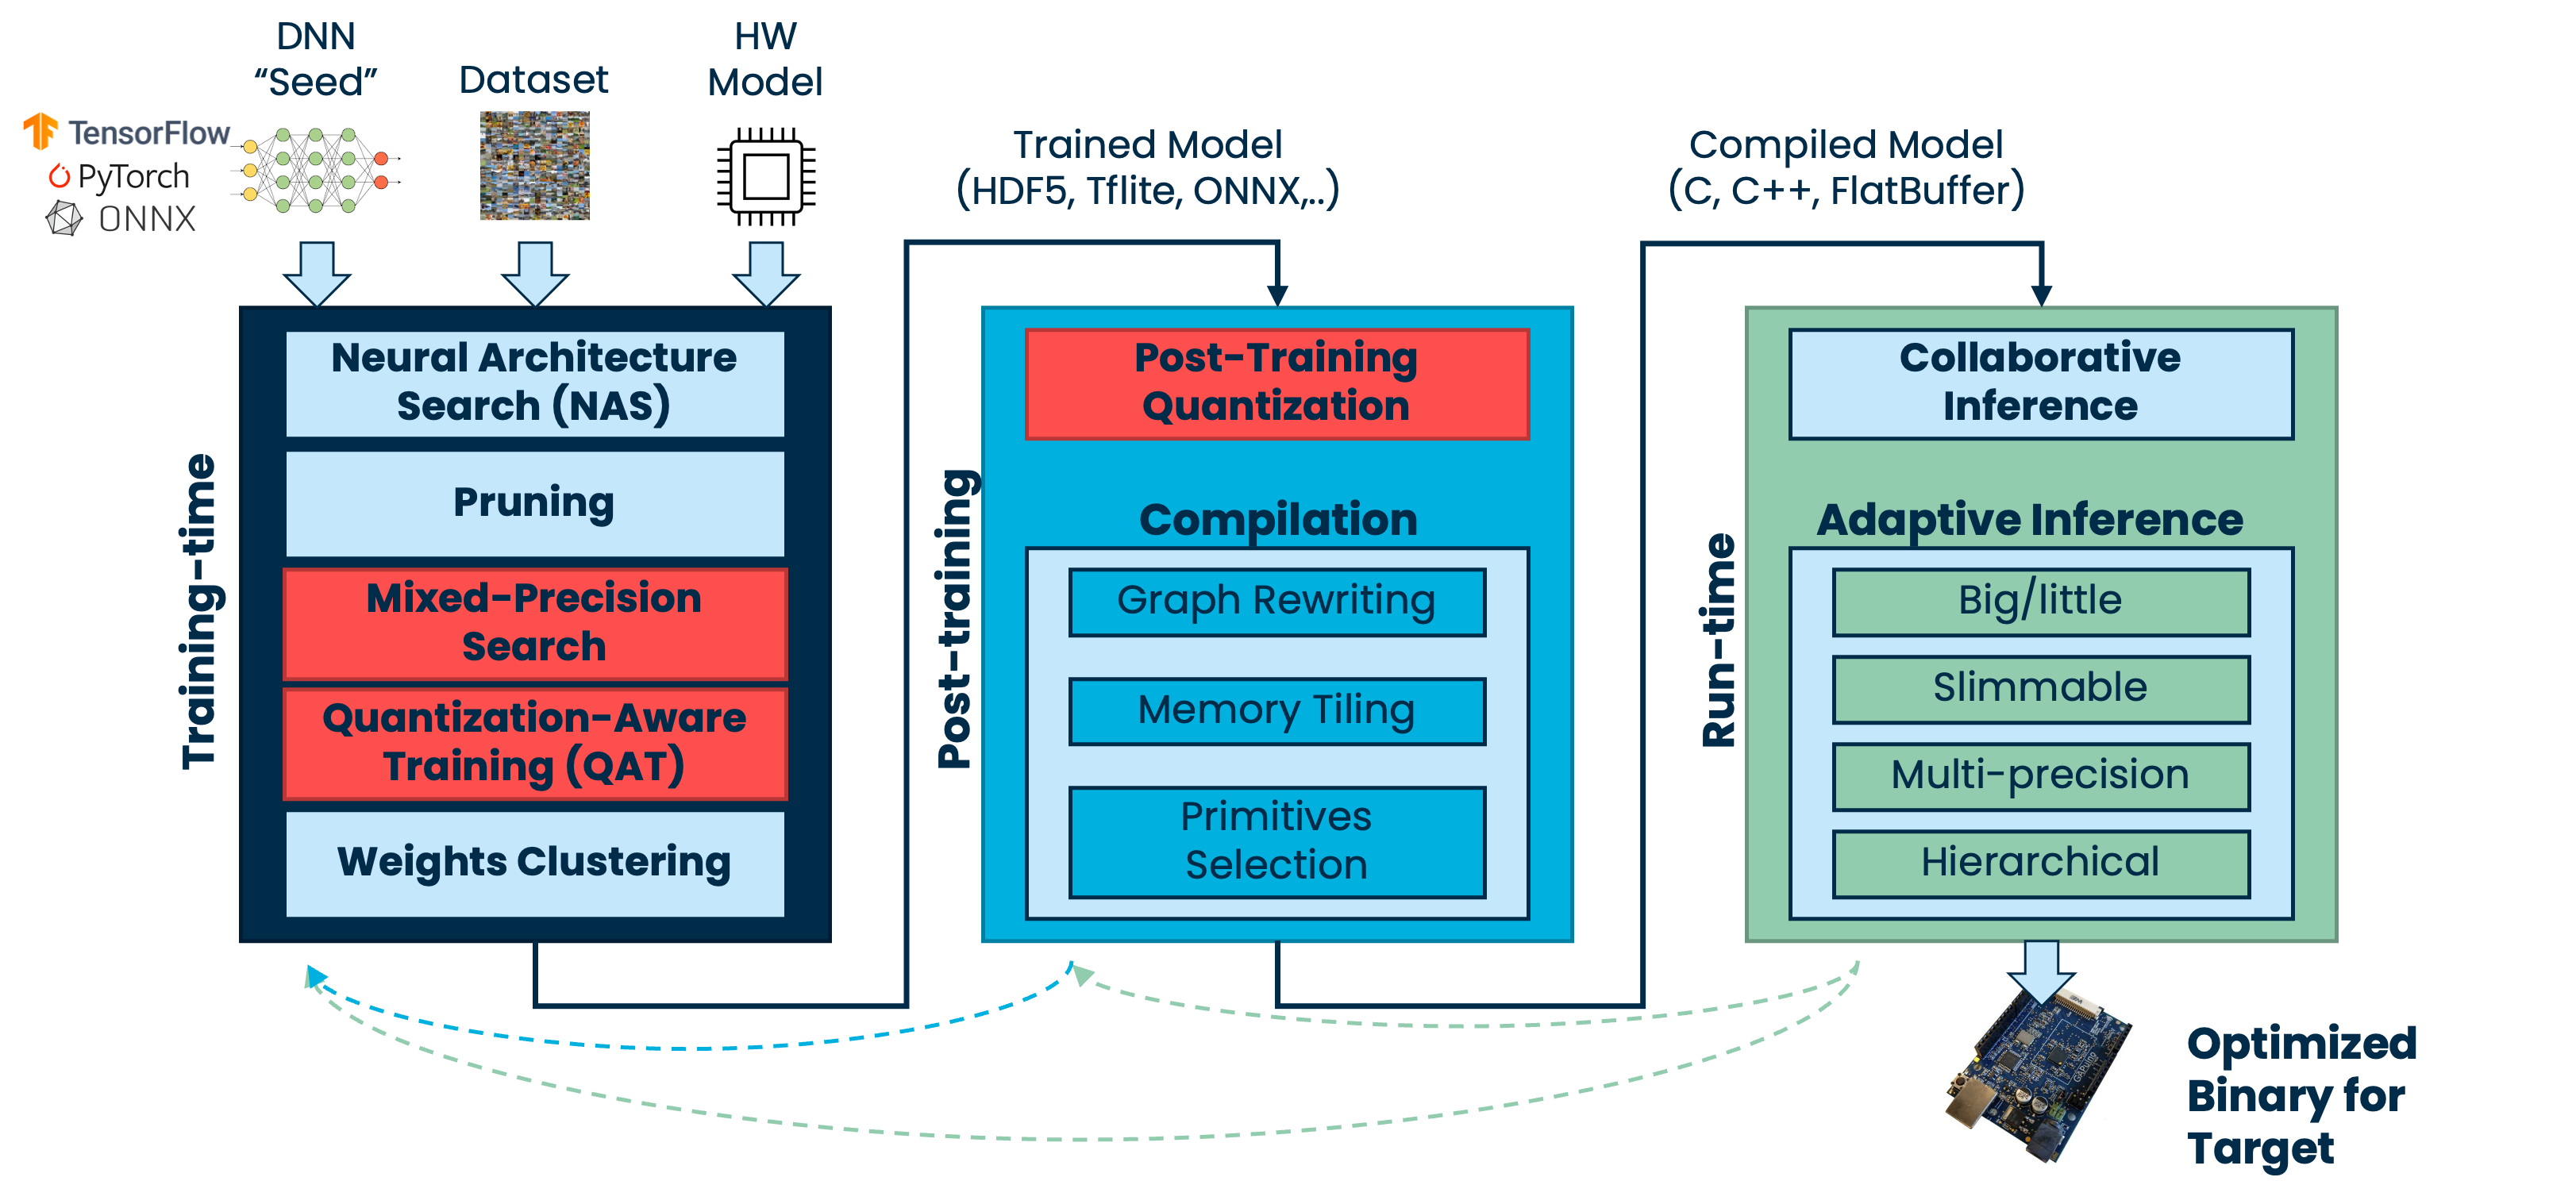

# Part 0: Initial Setup

**NOTE**: This part is identical to the previous notebooks, except for the imports and training settings.

## Setup for Kaggle or Google Colab

Run the following code if in Kaggle or Colab:

In [ ]:
#. !git clone https://github.com/eml-eda/oenne
#  %cd oenne

## Packages Installation

Install the required packages with pip if needed (**remember to re-comment these lines**):

In [ ]:
# standard Python libraries
#!pip install numpy pandas matplotlib seaborn torch torcheval torchinfo torchvision tqdm jupyterlab ipynb onnx
# the PLiNIO optimization library
#!pip install git+https://github.com/eml-eda/plinio.git@main#egg=plinio
# a helper library containing simple tinyML benchmarks and corresponding reference models
#!pip install git+https://github.com/eml-eda/pytorch-benchmarks.git@main#egg=pytorch-benchmarks

## Imports and Settings

As usual, we start by importing required libraries:

In [ ]:
import os
import sys
import json
import copy
from pathlib import Path

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torchinfo import summary

from plinio.cost import params_bit
from plinio.methods import MPS
from plinio.methods.mps import get_default_qinfo
from plinio.methods.mps.quant.quantizers import PACTAct
from plinio.methods.mps.quant.backends import Backend, integerize_arch
from plinio.methods.mps.quant.backends.match import MATCHExporter

import pytorch_benchmarks.image_classification as icl

from utils.train import set_seed

And repeat the initial configurations:

In [ ]:
SAVE_DIR = Path(f"experiments/03/")

TRAINING_CONFIG = {
    'in_class': False,          # kept for compatibility with hands-on #1. Leave it as false!
    'epochs': 50,               # max epochs for normal trainings
    'nas_epochs': 100,          # max epochs for the NAS search loop
    'nas_no_stop_epochs': 20,   # initial epochs without early stopping for the NAS
    'batch_size': 32,           # batch size
    'lr': 0.001,                # initial learning rate for normal trainings
    'search_lr_net': 0.001,     # learning rate for DNN weights during NAS
    'search_lr_nas': 0.001,     # learning rate for NAS parameters during NAS
    'weight_decay': 1e-4,       # weight decay for normal DNN parameters
    'patience': 10,             # early-stopping patience for normal trainings
    'nas_patience': 10,         # early-stopping patience for NAS search
}

set_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Working on: {device}")

# Part 1: Dataset Preparation

Dataset preparation is identical to the previous notebook:

In [ ]:
datasets = icl.get_data()
dataloaders = icl.build_dataloaders(datasets, batch_size=TRAINING_CONFIG['batch_size'])
train_dl, val_dl, test_dl = dataloaders

input_shape = datasets[0][0][0].numpy().shape
batch_shape = (1,) + input_shape

# Part 2: Quantization

All DNN models considered up to now used **32-bit floating point** for internal operations, and for storing weights and activations. However, our hardware target only supports Quantized DNN inference, using **8-bit integers**. Therefore, we need to convert our model to that format before we can export it and compile it.

Simply quantizing a model by replacing all floating point data with their closest integer approximation (the most basic form of Post-Training Quantization) could worsen its accuracy. Fortunately, this drop can often be recovered by running some epochs of the so-called **Quantization-Aware Training (QAT)**, as seen in class.

PLiNIO can be used to perform QAT, as well as to export the final "full integer" model in a format compatible with the compiler used in the next session.  

More precisely, PLiNIO's QAT function is embedded in the `MPS()` class, which actually performs a more advanced optimization: **Mixed-Precision Search**. This optimization applies QAT at *multiple bit-widths* simultaneously, and uses a SuperNet-like method to select the *best precision assignment* for the weights and activations of different portions of a DNN (different layers, or even different channels of the same layer).
The optimization can be driven by a two-terms loss function considering accuracy and cost, similar to the one used with SuperNet and PIT.

We will not use MPS in this session, since our target hardware and backend library do not support $<8$ bit inference. However, we can still use PLiNIO to perform a simple QAT run, by simply reducing it to a **"corner case" of MPS, with a single precision** (8-bit).

If you're interested in the details on the MPS algorithm present in PLiNIO, check-out these two papers: [link1](https://arxiv.org/abs/2206.08852), [link2](https://arxiv.org/abs/2004.05795). Feel free to also try applying MPS with multiple precisions on our DNN as an extra. Although we won't be able to deploy models with precisions different from 8-bit, it could still be interesting to check how much we can compress the weights without losing too much accuracy.

## Importing the Model

Let's start by loading the final model from Hands-on #2 (Optimized and Pruned):

In [ ]:
MODEL_PATH = Path("./experiments/02/final_model.pt")
model = torch.load(MODEL_PATH).eval()

Quickly verify that it's correctly loaded:

In [ ]:
criterion = nn.CrossEntropyLoss()
test_metrics = icl.evaluate(model, criterion, test_dl, device)
size = summary(model, batch_shape).total_params
print(f'Size: {size}, Test Loss: {test_metrics["loss"]}, Test Acc: {test_metrics["acc"]}')

## Preparing the Model

The constructor of the `MPS()` class in PLiNIO is similar to the ones of SuperNet and PIT. The parameters are similar, and the conversion is mostly transparent. 

Note that we can ignore the `cost` parameter, if we're interested in just QAT. When running an actual MPS optimization on the DNN weights, you can for instance set this parameter to `params_bit`, a cost model that tries to minimize the total occupation (in bits) of the DNN parameters.

The only key difference w.r.t. other PLiNIO optimization methods, is that `MPS` also expect a `qinfo` dictionary, containing settings on the desired type of quantization to apply for different parts of the network. The settings in `qinfo` include the quantization algorithm to use for weights and activations (e.g. min-max, PaCT, etc), and optional configuration parameters. In our case, it suffices to use the reasonable default settings provided by PLiNIO, by calling the `get_default_qinfo()` function. This function expects as input parameters the tuple of weights and activations bitwidths to be included in the optimization (in our case, only 8-bit for both).

There's just one thing to customize in the default `qinfo`, namely the range of the DNN **input** quantizer. In fact, since we know that our (float) data is in the $[0, 1]$ range, we can set the initial range of the quantizer to be the same. This should facilitate the conversion.

In [ ]:
# get the default qinfo dictionary, specifying 8-bit as the only precision for both weights and activations
qinfo = get_default_qinfo((8,), (8,))

# modify the default qinfo for the input layer, since we're using data in the [0, 1] range
qinfo['input_default']['quantizer'] = PACTAct
qinfo['input_default']['kwargs'] = {'init_clip_val': +1}

# call the PLiNIO constructor
mps_model = MPS(model, input_shape=input_shape, qinfo=qinfo)
mps_model = mps_model.to(device)

### Evaluate the Converted Model

The model generated by the MPS constructor has approximated weights and operations that simulate int8 precision. Furthermore, other optimizations are performed during the conversion, such as folding Batch Normalization layers with Convolutions or Linear layers (again), to avoid entirely their execution in the final deployed model. Overall, the result of the conversion is similar to what we would get with a (very basic) post-training quantization. Let's check how this model performs on our test data.

In [ ]:
criterion = nn.CrossEntropyLoss()
test_metrics = icl.evaluate(mps_model, criterion, test_dl, device)
print(f'Test Loss: {test_metrics["loss"]}, Test Acc: {test_metrics["acc"]}')

**Question**: Do you see an accuracy drop after conversion? If not, what does it mean?

## Running QAT

The actual execution of QAT is nothing more than an additional training run, using the model generated by the `MPS()` constructor. Note that, if we wanted to actually *select* the bitwidth using MPS, we would have to run something similar to the `nas_loop` seen in Hands-on #1 and #2. However, we're keeping a fixed precision, and do not aim to optimize the DNN cost (e.g. total memory occupation) in this phase. Or better, we already reduced memory by a factor of 4 by moving from float32 to int8, but now, our goal is just retrieving the (possible) lost accuracy.

So, in our case, a simple `training_loop` on the converted model will suffice.

In [ ]:
from ipynb.fs.defs.I_SuperNet import training_loop

criterion = nn.CrossEntropyLoss()
history = training_loop(SAVE_DIR / 'qat', TRAINING_CONFIG, mps_model, criterion, train_dl, val_dl, device)

### Evaluating the Model after QAT

Let's test the final model:

In [ ]:
test_metrics = icl.evaluate(mps_model, criterion, test_dl, device)
print(f'Final model cost: {mps_model.cost}, Test Loss: {test_metrics["loss"]}, Test Acc: {test_metrics["acc"]}')

After QAT, it is possible that your model has become even **slightly more accurate** than the floating point version! This sometimes happens when quantizing: the approximation introduced by quantization has a *regularizing* effect, which makes the model behave slightly better on unseen data.

# Part 3: Export for Deployment

We can now call the `.export()` method of the PLiNIO MPS model, exactly as done for SuperNet and PIT. Notice however, that in this case, the exporting phase has a slightly different behaviour. In fact, rather than outputting a model that includes standard PyTorch layers, we replace each quantized layer with a new class (for instance, `nn.Conv2D` becomes `QuantConv2D`). These layers function analogously to the torch equivalents, but also store the quantization parameters (e.g. min/max values for each weight tensor), and use them to simulate the effect of quantization during inference.

In [ ]:
final_mps_model = copy.deepcopy(mps_model)
quant_model = final_mps_model.export().eval()

Moreover, the model exported by MPS still only applies a so-called "fake quantization". This means that the DNN is not yet using *only* integer data. Rather, some parameters, such as the scale factors and zero offsets for (re-)quantization are still in floating point. To deploy on our target, however, all data should be integer. For instance, in the PULP-NN backend library that we will use on our target, the multiplication times a floating point scaling factor is replaced by the sequence of: i) an integer multiplication and ii) a right shift.

To obtain a model that fully complies with this execution model, we need a further conversion step. This is implemented by the next cell, which calls the `integerize_arch` function, which specifies the desired backend, among the supported ones, and some other optional parameters. The backend essentially refers to the compiler that will be used to take the model and convert it to inference code for the hardware. In our case, it will be the [MATCH](https://github.com/eml-eda/match) compiler.

In [ ]:
# convert the model to full-integer, compiler-compliant format
full_int_model = integerize_arch(quant_model, Backend.MATCH, backend_kwargs={'shift_pos': 16})
full_int_model = full_int_model.to(device)

Since the previous conversion removes all floating point operations from the network, it might affect the accuracy. Let's verify by how much.

In [ ]:
test_metrics = icl.evaluate(full_int_model, criterion, test_dl, device)
print(f'Test Loss: {test_metrics["loss"]}, Test Acc: {test_metrics["acc"]}')

We now have to save the final model. In this case, differently from Hands-on #1 and #2, we don't need to save it in PyTorch format. Rather, we generate an ONNX file compatible with what the MATCH compiler expects. The following cell does that (you can safely ignore the warnings that appear).

In [ ]:
exporter = MATCHExporter()
exporter.export(copy.deepcopy(full_int_model), batch_shape, SAVE_DIR)

Last but not least, we also have to save the "clip value" used by our quantized model to convert inputs (originally real values in [0, 1]) to 8-bit integers. 

The MPS class in PLiNIO (and the following integerization step) use an "Input Quantizer" layer to perform this transformation. The Input Quantizer is of type `PACTAct`, as specified in the `qinfo` data structure above. This type of quantizer learns a clipping (i.e. saturation) value for the input tensor. It then rescales the data between 0 and this value to occupy the full int8 range. Mathematically, the operation performed, for unsigned 8-bit data, is the following:

$$X_{int} = \left\lfloor \frac{255}{\alpha} \cdot \min(X_{float}, \alpha) \right\rfloor $$


where $\alpha$ is the learned clipping value. At the beginning of our QAT, we initialized $\alpha = 1$. However, this value is trainable, so it could have changed during the QAT execution. So, let's extract the clipping value from the full integer model, and save it on disk for later usage. We will use a simple JSON dictionary for this:


In [ ]:
qtz = full_int_model.input_1_input_quantizer
clip_val = float(qtz.out_quantizer.clip_val)
print(f"Input clipping value: {clip_val}")

scaling_dict = {'clip_val': clip_val}
with open(f"{SAVE_DIR}/rescaling_values.json", "w") as f:
    json.dump(scaling_dict, f)

You will probably see that the clipping value remained very close to the initialization value (+1). This simply means that our model has learned to avoid any clipping, and map the entire input range to the uint8 range. We kept this last step for generality, as it could be very important on other datasets.